In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# load Marius' V1 data
data_dir = 'data/V1_data_Marius/rf3x_TX61.npz'
with np.load(data_dir) as data:
    rf =  data['rf']
    xpos = data['xpos']
    ypos = data['ypos']
    snr = data['snr']

### Average the receptive fields of all 3 repeat experiments 

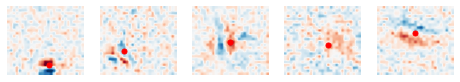

In [3]:
# average all 3 repeats
avg_rf = np.mean(rf, axis=0)
avg_rf = avg_rf.reshape(-1, 24 * 27)

# normalize
avg_rf = (avg_rf - np.mean(avg_rf, axis=1).reshape(-1, 1)) / np.std(avg_rf, axis=1).reshape(-1, 1)

# select top 10k highest snr neurons
snr_thresh = 0.4
avg_rf = avg_rf[snr > snr_thresh]

# visuzlie a few neurons along with their center of mass
from scipy import ndimage
# np.random.seed(10)
fig = plt.figure(figsize=(8, 8))
for i in range(5):
    ax = fig.add_subplot(1, 5, i + 1)
    idx = np.random.randint(0, len(avg_rf))
    cell_rf =  avg_rf[idx].reshape(24, 27)
    com = np.round(ndimage.measurements.center_of_mass(np.abs(cell_rf) ** 4))
    plt.imshow(cell_rf, cmap='RdBu')
    plt.plot(com[1], com[0], 'ro', markersize=5)
    plt.clim(-5, 5)
    plt.axis('off')

In [4]:
from skimage.transform import downscale_local_mean, resize
from scipy import ndimage

# center the receptive fields
num_cells = len(avg_rf)
dim_to_reshape = 24
processed_rf = np.zeros((num_cells, 24 * 27))

for i in range(num_cells):
    cell_rf = avg_rf[i]
    cell_rf = cell_rf.reshape(24, 27)


    # calculate the center of mass
    center_of_mass = ndimage.measurements.center_of_mass(np.abs(cell_rf) ** 4)
    center_of_mass = np.round(center_of_mass).astype('int')


    # translate rf to (12, 13) but wrap around
    cell_rf_centered = np.roll(cell_rf, 12 - center_of_mass[0], axis=0)
    cell_rf_centered = np.roll(cell_rf_centered, 13 - center_of_mass[1], axis=1)
    processed_rf[i] = cell_rf_centered.flatten()

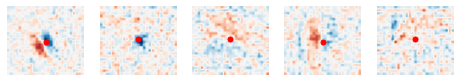

In [14]:
# plot a few receptive fields to visualize
from scipy import ndimage
# np.random.seed(10)
fig = plt.figure(figsize=(8, 8))
for i in range(5):
    ax = fig.add_subplot(1, 5, i + 1)
    idx = np.random.randint(0, len(avg_rf))
    cell_rf =  processed_rf[idx].reshape(24, 27)
    com = np.round(ndimage.measurements.center_of_mass(np.abs(cell_rf)))
    plt.imshow(cell_rf, cmap='RdBu')
    plt.plot(com[1], com[0], 'ro', markersize=5)
    plt.clim(-5, 5)
    plt.axis('off')

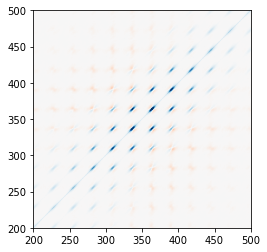

In [6]:
# compute data covariance
cov_data = processed_rf.T @ processed_rf
cov_data *= cov_data.shape[1] / np.trace(cov_data)

fig = plt.figure()
plt.imshow(cov_data, cmap='RdBu')
plt.xlim(200, 500)
plt.ylim(200, 500)
plt.clim(-4, 4)

Data: 100 evecs explain 0.51 variance


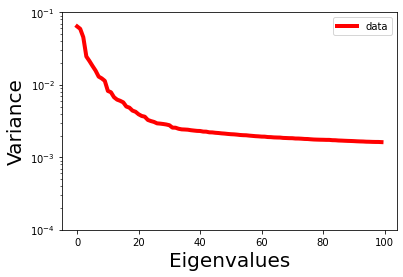

In [7]:
import numpy.linalg as la 

# generate eigenvectors and eigenvalues
eval_data, evec_data = la.eigh(cov_data)

# plot evals
eval_data /= np.sum(eval_data)

t = 100
fig = plt.figure()
plt.semilogy(np.flip(eval_data)[:t], lw=4, c='r', label='data')
plt.ylim(1e-4, 1e-1)
plt.legend()
plt.xlabel('Eigenvalues', fontsize=20)
plt.ylabel('Variance', fontsize=20)

print('Data: %d evecs explain %0.2f variance' % (t, np.sum(eval_data[-t:])))

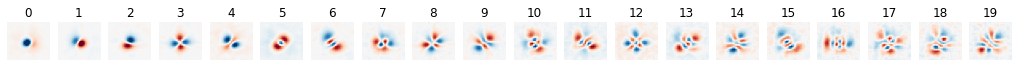

In [8]:
# plot evecs
fig = plt.figure(figsize=(18, 7))
# plt.suptitle('Eigenfunctions from top: Data, model, finite neurons, analytical')
for i in range(20):
    ax = fig.add_subplot(1, 20, i + 1)
    plt.imshow(evec_data[:, - i - 1].reshape(24, 27), cmap='RdBu')
    plt.title(i)
    plt.clim(-0.2, 0.2)
    plt.axis('off')

In [ ]:
## write a script to load the data, normalize, and center all receptive fields

# average the receptive fields

# fit optimal values to data
# have to modify the V1_covariance function to generate non-square receptive fields
# possible mod: able to pass a tuple as dimensions. if tuple, discretize the grid separately

# generate eigenfunctions and eigenvalues

# plot all eigenfunctions

# plot all eigenvalues 

array([1794.66666667, 1640.        , 1634.66666667, ...,  301.33333333,
        421.33333333,  181.33333333])